# Import libraries

In [90]:
# General
import os
import pathlib
import pickle

# Analysis
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sn

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,cross_val_score

# Autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Import project preprocessed data
from package_folder import preprocessor_light 

# 1. Load data, create X and Y, preprocess

In [6]:
#Load raw data
ROOT_PATH = pathlib.Path().resolve().parent # Get the parent directory of the current working directory
raw_data_path = os.path.join(ROOT_PATH, 'raw_data', 'Loan_Default.csv')
print(raw_data_path)

/home/yann/code/YannAll/automated_loan_review_project/raw_data/Loan_Default.csv


In [7]:
data = pd.read_csv(raw_data_path)

In [29]:
data.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')

In [8]:
full_pipeline = preprocessor_light.create_preprocessing_pipeline()

In [9]:
full_pipeline

Pipeline(steps=[('cleaner', DataCleaner()), ('dropper', ColumnDropper()),
                ('cat_imputer', CategoricalImputer()),
                ('encoder', CategoricalEncoder()),
                ('simple_imputer', SimpleImputerTransformer()),
                ('outlier_remover', OutlierRemover()),
                ('scaler', MinMaxScalerTransformer())])

In [10]:
data_processed=full_pipeline.fit_transform(data)

✅ Data cleaned
✅ Columns ['rate_of_interest','credit_type','year','ID','dtir1','Upfront_charges', 'LTV', 'Interest_rate_spread'] dropped
✅ Missing values in categorical variables imputed
✅ Categorical variables encoded successfully, including 'term'
✅ Missing values imputed with Simple Imputer (mean), remaining NaNs filled with 0
✅ Outliers removed based on IQR threshold
✅ Continuous variables scaled between 0 and 1


In [11]:
X = data_processed.drop(columns='loan_amount')
y = data_processed["loan_amount"]

In [12]:
X_column_names=list(X.columns)

In [13]:
print(f"X_shape: {X.shape} y shape: {y.shape}")

X_shape: (144218, 86) y shape: (144218,)


# 2. Instantiate, cross validate, train and evaluate the base model

In [14]:
#Instantiate basic regression model
linear_regression=LinearRegression(n_jobs=1000)

In [15]:
#Create train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
#Cross validate data
from sklearn.model_selection import cross_validate
base_model_score=cross_validate(linear_regression,X_train,y_train,cv=5,verbose=0)['test_score'].mean()
print(f"base model: {base_model_score}")

base model: -298638895829543.56


In [17]:
#Observation: the R2 of this regression is unusually negative. It signals a problem with the input data.
#Assumption: the problem is the high colinearity between our features

<Axes: >

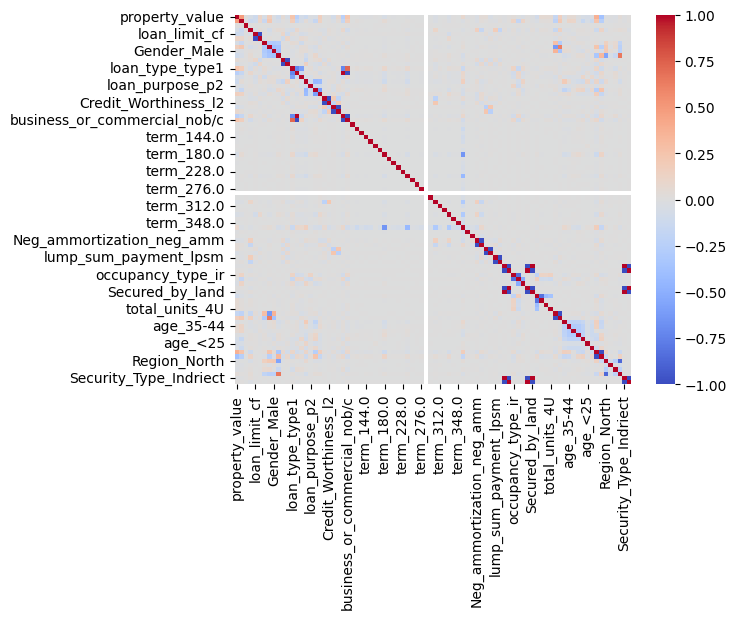

In [18]:
#Visualize colinearity
sn.heatmap(X_train.corr(),cmap='coolwarm')

# 3. Instantiate, cross validate, train and evaluate the base model AFTER dimensionality reduction

In [96]:
#Import preprocessing pipeline from package folder
from package_folder import preprocessor_for_regression
data_processed_PCA = preprocessor_for_regression.process_data()

🔍 Checking for file at path: /home/yann/code/YannAll/automated_loan_review_project/raw_data/Loan_Default.csv
✅ Data loaded successfully
0
✅ Data cleaned
✅ Missing values in categorical variables imputed
✅ Categorical variables encoded successfully, including 'term'
✅ Missing values imputed with Simple Imputer (mean), remaining NaNs filled with 0
✅ Continuous variables scaled and centered around 0
✅ Dimensionality reduced to 24 features with a PCA


In [97]:
columns=[f"PC{i}" for i in range(1,25)]+['rate_of_interest']
data_processed_PCA = pd.DataFrame(data_processed_PCA,columns=columns)

In [98]:
linear_regression=LinearRegression(n_jobs=100)

In [99]:
#Create X and y 
X = data_processed_PCA.drop(columns='rate_of_interest')
y = data_processed_PCA["rate_of_interest"]

In [100]:
#Train test split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

<Axes: >

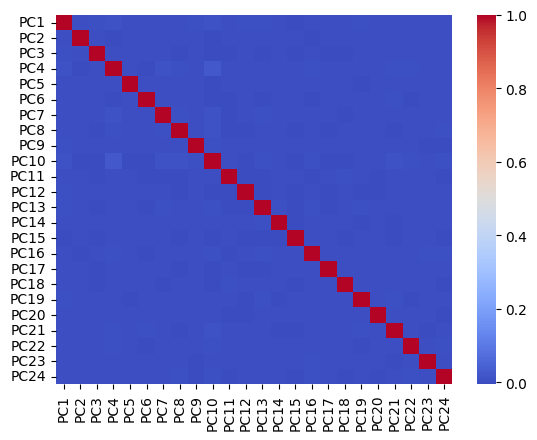

In [101]:
#Visualize colinearity
sn.heatmap(X_train.corr(),cmap='coolwarm')

In [102]:
#Cross validate X dataset reduced thanks to PCA 
cv_results=cross_validate(linear_regression,X_train,y_train,cv=5,verbose=0)['test_score'].mean()
print(f"CV results: {cv_results}")

CV results: 0.6368458936982362


In [103]:
#Fit the model
linear_regression.fit(X_train,y_train)

LinearRegression(n_jobs=100)

In [104]:
#Predict on X_test
y_pred_scaled=linear_regression.predict(X_test)

In [73]:
y_pred_scaled

array([3.65433316, 3.91025825, 4.57467467, ..., 4.06811057, 4.06797879,
       4.6530643 ])

In [63]:
y_test

40871    4.180
61241    3.750
21254    4.750
18759    4.625
52386    4.875
         ...  
59844    4.000
56962    3.625
8987     3.990
11579    3.990
2762     4.500
Name: rate_of_interest, Length: 19638, dtype: float64

In [ ]:
#Conclusion: this looks quite promising. Let's now see if we can improve performance a bit by tuning the model!

In [105]:
#Dump linear regression model into a pickle file
linear_regression_model_path = os.path.join(ROOT_PATH, 'models', 'linear_regression')
with open(linear_regression_model_path, 'wb') as file: 
     pickle.dump(linear_regression, file)
print(f"linear_regression successfully saved to {linear_regression_model_path}")

linear_regression successfully saved to /home/yann/code/YannAll/automated_loan_review_project/models/linear_regression


## 4. Model tuning

In [80]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

# Instantiate model
model = ElasticNet()

# Hyperparameter Grid
grid = {'l1_ratio': stats.uniform(0, 1), 'alpha': [0.001, 0.01, 0.1, 1]}

# Instantiate Grid Search
search = RandomizedSearchCV(
    model,
    grid,
    scoring='r2',
    n_iter=100,  # number of draws
    cv=5, n_jobs=-1
)

# Fit data to Grid Search
search.fit(X_train, y_train)

#Print results
# Best score
print(search.best_score_)

# Best Params
print(search.best_params_)

# Best estimator
print(search.best_estimator_)

0.6368291912270192
{'alpha': 0.001, 'l1_ratio': np.float64(0.12459624612476872)}
ElasticNet(alpha=0.001, l1_ratio=np.float64(0.12459624612476872))
